In [1]:
import argparse
from matplotlib import pyplot as plt
import pandas as pd
import time

import ray
from ray import air, tune
from ray.rllib.algorithms.bandit import BanditLinUCBConfig
ignore_reinit_error=True

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.12) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [2]:
from recsim import choice_model
from recsim.environments import (
    long_term_satisfaction as lts,
    interest_evolution as iev,
    interest_exploration as iex,
)

from ray.rllib.env.wrappers.recsim import make_recsim_env
from ray.tune import register_env



# Long-term satisfaction env: User has to pick from items that are either
# a) unhealthy, but taste good, or b) healthy, but have bad taste.
# Best strategy is to pick a mix of both to ensure long-term
# engagement.


def lts_user_model_creator(env_ctx):
    return lts.LTSUserModel(
        env_ctx["slate_size"],
        user_state_ctor=lts.LTSUserState,
        response_model_ctor=lts.LTSResponse,
    )


def lts_document_sampler_creator(env_ctx):
    return lts.LTSDocumentSampler()


LongTermSatisfactionRecSimEnv = make_recsim_env(
    recsim_user_model_creator=lts_user_model_creator,
    recsim_document_sampler_creator=lts_document_sampler_creator,
    reward_aggregator=lts.clicked_engagement_reward,
)


# Interest exploration env: Models the problem of active exploration
# of user interests. It is meant to illustrate popularity bias in
# recommender systems, where myopic maximization of engagement leads
# to bias towards documents that have wider appeal,
# whereas niche user interests remain unexplored.
def iex_user_model_creator(env_ctx):
    return iex.IEUserModel(
        env_ctx["slate_size"],
        user_state_ctor=iex.IEUserState,
        response_model_ctor=iex.IEResponse,
        seed=env_ctx["seed"],
    )


def iex_document_sampler_creator(env_ctx):
    return iex.IETopicDocumentSampler(seed=env_ctx["seed"])


InterestExplorationRecSimEnv = make_recsim_env(
    recsim_user_model_creator=iex_user_model_creator,
    recsim_document_sampler_creator=iex_document_sampler_creator,
    reward_aggregator=iex.total_clicks_reward,
)


def iev_user_model_creator(env_ctx):
    return iev.IEvUserModel(
        env_ctx["slate_size"],
        choice_model_ctor=choice_model.MultinomialProportionalChoiceModel,
        response_model_ctor=iev.IEvResponse,
        user_state_ctor=iev.IEvUserState,
        seed=env_ctx["seed"],
    )


# Extend IEvVideo to fix a bug caused by None cluster_ids.
class SingleClusterIEvVideo(iev.IEvVideo):
    def __init__(self, doc_id, features, video_length=None, quality=None):
        super(SingleClusterIEvVideo, self).__init__(
            doc_id=doc_id,
            features=features,
            cluster_id=0,  # single cluster.
            video_length=video_length,
            quality=quality,
        )


def iev_document_sampler_creator(env_ctx):
    return iev.UtilityModelVideoSampler(doc_ctor=iev.IEvVideo, seed=env_ctx["seed"])


InterestEvolutionRecSimEnv = make_recsim_env(
    recsim_user_model_creator=iev_user_model_creator,
    recsim_document_sampler_creator=iev_document_sampler_creator,
    reward_aggregator=iev.clicked_watchtime_reward,
)


# Backward compatibility.
register_env(
    name="RecSim-v1", env_creator=lambda env_ctx: InterestEvolutionRecSimEnv(env_ctx)
)

In [3]:
ray.init()

E0330 10:55:01.254946493   29252 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies
E0330 10:55:01.307065151   29252 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies
E0330 10:55:02.142307348   29252 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies
E0330 10:55:02.167078959   29252 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies
2023-03-30 10:55:02,206	INFO worker.py:1553 -- Started a local Ray instance.


Python version:,3.8.10
Ray version:,2.3.1


Running training for 50 time steps


(raylet) /usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.12) or chardet (3.0.4) doesn't match a supported version!
(raylet)   warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
(BanditLinUCB pid=29714) 2023-03-30 10:55:08,830	WARNING algorithm_config.py:596 -- Cannot create BanditLinUCBConfig from given `config_dict`! Property __stdout_file__ not supported.
(BanditLinUCB pid=29714) 2023-03-30 10:55:09,031	INFO algorithm.py:506 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
(BanditLinUCB pid=29714) /home/kshitij/.local/lib/python3.8/site-packages/gymnasium/wrappers/compatibility.py:67: DeprecationWarning: WARN: The `gymnasium.make(..., apply_api_compatibility=...)` parameter is deprecated and will be removed in v0.29. Instead use `gym.make('GymV21Environment-v0', env_name=...)` or `from shimmy import GymV21CompatibilityV0`
(BanditLinUCB pid=29714)   l

Trial name,agent_timesteps_total,connector_metrics,counters,custom_metrics,date,done,episode_len_mean,episode_media,episode_reward_max,episode_reward_mean,episode_reward_min,episodes_this_iter,episodes_total,experiment_id,hostname,info,iterations_since_restore,node_ip,num_agent_steps_sampled,num_agent_steps_trained,num_env_steps_sampled,num_env_steps_sampled_this_iter,num_env_steps_trained,num_env_steps_trained_this_iter,num_faulty_episodes,num_healthy_workers,num_in_flight_async_reqs,num_remote_worker_restarts,num_steps_trained_this_iter,perf,pid,policy_reward_max,policy_reward_mean,policy_reward_min,sampler_perf,sampler_results,time_since_restore,time_this_iter_s,time_total_s,timers,timestamp,timesteps_since_restore,timesteps_total,training_iteration,trial_id,warmup_time
BanditLinUCB_RecSim-v1_39ae5_00000,5000,"{'ObsPreprocessorConnector_ms': 0.017602820145456416, 'StateBufferConnector_ms': 0.0038887325086091693, 'ViewRequirementAgentConnector_ms': 0.24856182566860266}","{'num_env_steps_sampled': 5000, 'num_env_steps_trained': 5000, 'num_agent_steps_sampled': 5000, 'num_agent_steps_trained': 5000}",{},2023-03-30_10-55-27,True,86.7719,{},199.429,155.208,116,1,57,f0a9e58195394270a9e3900613345cfe,kshitij-Inspiron-5570,"{'learner': {'default_policy': {'learner_stats': {'update_latency': 0.0005545616149902344}}}, 'num_env_steps_sampled': 5000, 'num_env_steps_trained': 5000, 'num_agent_steps_sampled': 5000, 'num_agent_steps_trained': 5000}",50,192.168.223.125,5000,5000,5000,100,5000,100,0,0,0,0,100,"{'cpu_util_percent': 23.6, 'ram_util_percent': 67.3}",29714,{},{},{},"{'mean_raw_obs_processing_ms': 0.877096407239162, 'mean_inference_ms': 0.617393617662609, 'mean_action_processing_ms': 0.11241692166195733, 'mean_env_wait_ms': 0.6494790027413037, 'mean_env_render_ms': 0.0}","{'episode_reward_max': 199.4290802344897, 'episode_reward_min': 116.0, 'episode_reward_mean': 155.20770604227926, 'episode_len_mean': 86.7719298245614, 'episode_media': {}, 'episodes_this_iter': 1, 'policy_reward_min': {}, 'policy_reward_max': {}, 'policy_reward_mean': {}, 'custom_metrics': {}, 'hist_stats': {'episode_reward': [141.13122623574142, 136.0, 136.62156382987592, 150.02202608496754, 144.69723167993462, 144.0, 144.0, 155.67337416308922, 140.0, 160.0, 160.0, 160.84792865846728, 196.81957626665658, 188.0, 148.88921619850808, 147.1715742926611, 136.0, 116.0, 156.0, 160.341055605909, 169.25616574539228, 161.2662718035141, 166.80136258046616, 160.0, 145.14721402638128, 140.0, 158.08076584184903, 164.0, 155.40264684292606, 166.85530950338932, 168.0, 149.48685067666915, 138.44897769213466, 152.82955032744414, 141.12652159594876, 172.0, 161.28346987346143, 148.0, 158.3701068520367, 156.23987304362427, 148.64553552623738, 156.0, 140.7144065698567, 148.6905696994657, 199.4290802344897, 174.4691244716009, 145.78386542611045, 152.69265301345095, 147.7723188058236, 156.97536508885807, 191.7445026659789, 156.0, 154.0271798046958, 147.73290578786754, 156.0, 176.96345755486576, 138.3884203395668], 'episode_lengths': [85, 65, 57, 76, 75, 68, 93, 96, 93, 78, 63, 92, 118, 103, 109, 93, 82, 96, 104, 88, 82, 78, 79, 119, 77, 66, 110, 87, 60, 99, 84, 98, 139, 79, 106, 74, 87, 109, 84, 65, 85, 71, 74, 75, 110, 80, 64, 84, 74, 81, 134, 92, 72, 68, 92, 97, 77]}, 'sampler_perf': {'mean_raw_obs_processing_ms': 0.877096407239162, 'mean_inference_ms': 0.617393617662609, 'mean_action_processing_ms': 0.11241692166195733, 'mean_env_wait_ms': 0.6494790027413037, 'mean_env_render_ms': 0.0}, 'num_faulty_episodes': 0, 'connector_metrics': {'ObsPreprocessorConnector_ms': 0.017602820145456416, 'StateBufferConnector_ms': 0.0038887325086091693, 'ViewRequirementAgentConnector_ms': 0.24856182566860266}}",16.9739,0.40763,16.9739,"{'training_iteration_time_ms': 4.597, 'load_time_ms': 0.199, 'load_throughput': 5027.936, 'learn_time_ms': 1.104, 'learn_throughput': 906.093, 'synch_weights_time_ms': 0.03}",1680153927,0,5000,50,39ae5_00000,0.0704014


2023-03-30 10:55:27,398	INFO tune.py:798 -- Total run time: 23.48 seconds (23.00 seconds for the tuning loop).


The trials took 23.508825540542603 seconds



/tmp/ipykernel_29252/3034082031.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  frame = frame.append(result.metrics_dataframe, ignore_index=True)


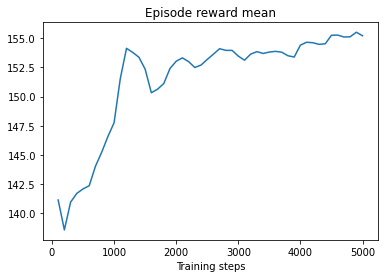

In [4]:

config = (
    BanditLinUCBConfig()
    .environment(
        "RecSim-v1",
        env_config={
            "num_candidates": 10,
            "slate_size": 2,
            "convert_to_discrete_action_space": True,
            "wrap_for_bandits": True,
        },
    ).framework("torch", eager_tracing="torch"=="tf2")
)

# Actual env timesteps per `train()` call will be
# 10 * min_sample_timesteps_per_iteration (100 by default) = 1000
training_iterations = 50
min_sample_timesteps_per_iteration=1000

print("Running training for %s time steps" % training_iterations)

start_time = time.time()
tuner = tune.Tuner(
    "BanditLinUCB",
    param_space=config.to_dict(),
    run_config=air.RunConfig(
        stop={"training_iteration": training_iterations},
        checkpoint_config=air.CheckpointConfig(
            checkpoint_at_end=False,
        ),
    ),
    tune_config=tune.TuneConfig(
        num_samples=1,
    ),
)
results = tuner.fit()

print("The trials took", time.time() - start_time, "seconds\n")

# Analyze cumulative regrets of the trials
frame = pd.DataFrame()
for result in results:
    frame = frame.append(result.metrics_dataframe, ignore_index=True)
x = frame.groupby("agent_timesteps_total")["episode_reward_mean"].aggregate(
    ["mean", "max", "min", "std"]
)

plt.plot(x["mean"])
plt.fill_between(
    x.index, x["mean"] - x["std"], x["mean"] + x["std"], color="b", alpha=0.2
)
plt.title("Episode reward mean")
plt.xlabel("Training steps")
plt.show()

In [5]:
ray.shutdown()